Install PyTorch Geometric (Colab Setup)

In [2]:
# Install PyTorch and PyTorch Geometric dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric


Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 115.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.8 MB/s e

Import Libraries

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Load Cora Dataset

In [4]:
# Download and load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

print(data)
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of node features: {dataset.num_node_features}')


Processing...


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of classes: 7
Number of node features: 1433


Done!


Visualize the Graph

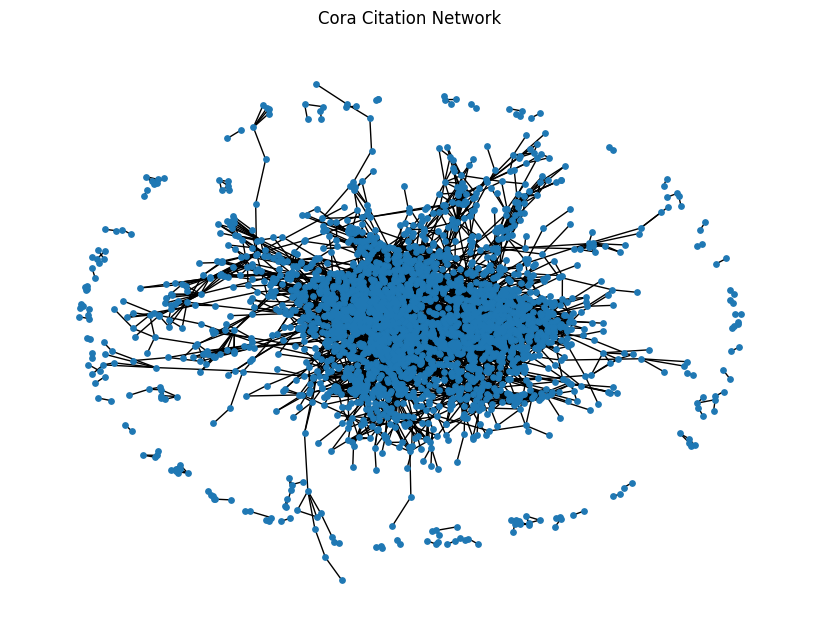

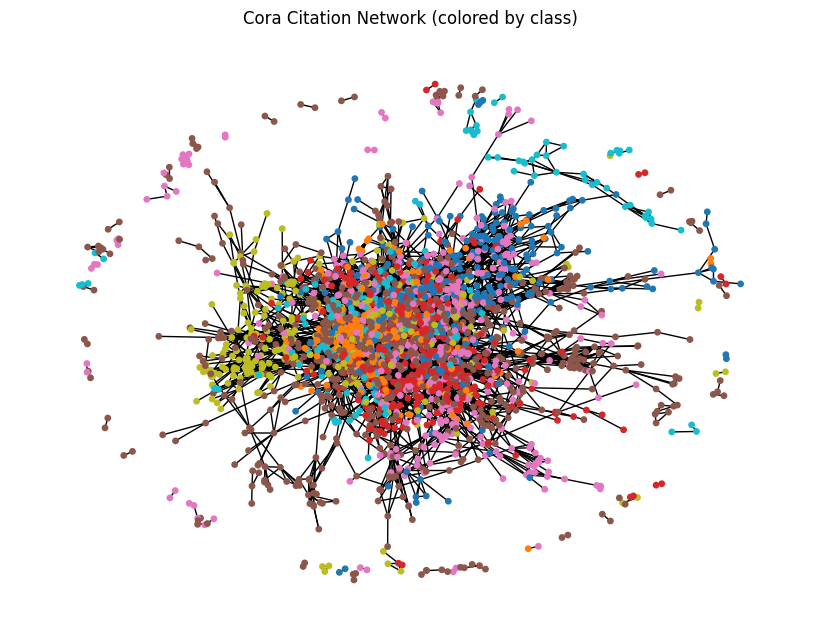

In [5]:
# Convert PyG graph to NetworkX and visualize
G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(8, 6))
nx.draw(G, node_size=15, with_labels=False)
plt.title("Cora Citation Network")
plt.show()


y = data.y.numpy()  # class labels
plt.figure(figsize=(8, 6))
nx.draw(G, node_size=15, node_color=y, cmap=plt.cm.tab10, with_labels=False)
plt.title("Cora Citation Network (colored by class)")
plt.show()

Define the GCN Model

In [9]:
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.dropout = nn.Dropout(p=0.5)  # try 0.5 dropout
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


Train the GCN

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, 16, dataset.num_classes).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(201):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}: Loss = {loss:.4f}')


Epoch 0: Loss = 1.9374
Epoch 20: Loss = 0.1987
Epoch 40: Loss = 0.0643
Epoch 60: Loss = 0.0482
Epoch 80: Loss = 0.0296
Epoch 100: Loss = 0.0288
Epoch 120: Loss = 0.0285
Epoch 140: Loss = 0.0555
Epoch 160: Loss = 0.0226
Epoch 180: Loss = 0.0387
Epoch 200: Loss = 0.0390


Evaluate the Model

In [11]:
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')


Accuracy: 0.8040


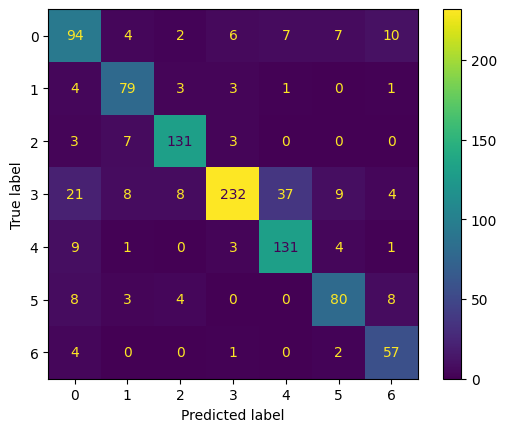

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
conf_mat = confusion_matrix(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
plt.show()
